## Example notebook for fluid2d cases with xarray

Read/plot particles positions and recompute the associated analytical velocity field

In [1]:
import os,sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

#######

Pyticles_folder = "/home/gula/Desktop/Work_capella/LCS/fluid2d/Pyticles/"

# Specific modules needed for pyticles
sys.path.append(Pyticles_folder + "Modules/") 
import pyticles_sig_sa as part

# Load particles

In [2]:
lag_file = Pyticles_folder + "out/vortex_00_test_adv0000m_16_0000.nc"

# Open dataset
lag = xr.open_dataset(lag_file)

# check what is inside the file
lag

<xarray.Dataset>
Dimensions:     (time: 72, nq: 40401)
Coordinates:
  * time        (time) float32 0.0 1.0 2.0 3.0 4.0 ... 67.0 68.0 69.0 70.0 71.0
Dimensions without coordinates: nq
Data variables:
    ocean_time  (time) float32 ...
    px          (time, nq) float64 ...
    py          (time, nq) float64 ...
Attributes: (12/37)
    w_sed0:         0.0
    depth:          0
    meanflow:       0
    initial_depth:  0
    dfile:          1
    dx0:            1
    ...             ...
    sedimentation:  0
    ic:             64
    jc:             64
    lev0:           -1
    lev1:           -1
    depth0:         0

# Plot particles positions at the initial (time = 0) and last time (time=-1)

0 0
1 -1
CPU times: user 82.5 ms, sys: 18.9 ms, total: 101 ms
Wall time: 189 ms


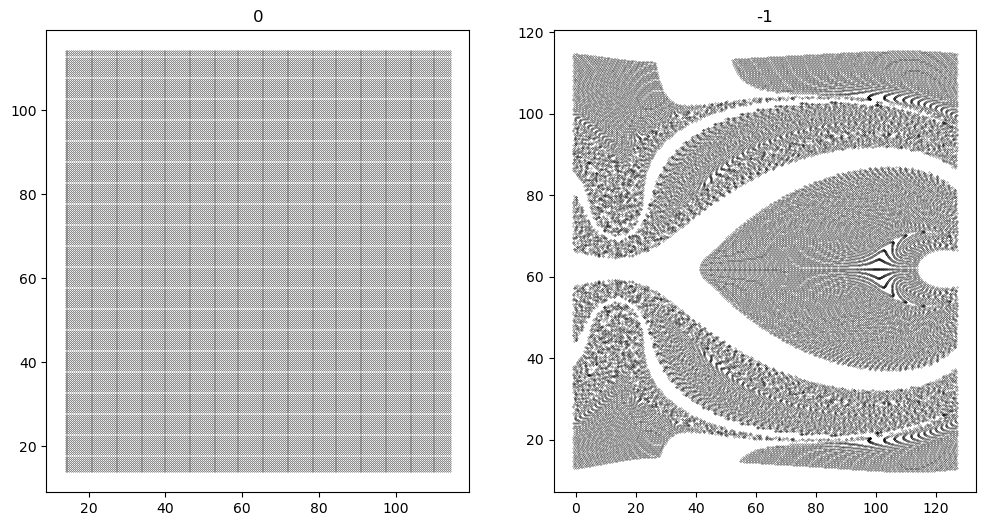

In [3]:
%%time

f, axes = plt.subplots(1, 2,figsize=(12,6))

marksize=0.2; colorpoint = 'black'; colorpointedge='black'
    
for it,time in enumerate([0,-1]):

    print(it,time)
    ax = axes[it]
    px = lag.px.isel(time=time)
    py = lag.py.isel(time=time)

    ax.set_title(time)
    # plot particles position on the domain
    ax.plot(px,py,'o',markersize=marksize,\
            markerfacecolor=colorpoint, markeredgecolor=colorpointedge)



## Load velocity field from fluid2d

In [16]:
# read info about simulation in file:

print(lag.source)

# Load grid parameters (from particle file)
simul = part.fluid2d_load('vortex',lag.source_file, L=1)

nxi,nyi = simul.coord[3],simul.coord[1]



fluid2d


coord is  [0, 128, 0, 128]


Text(0.5, 1.0, "<xarray.DataArray 'px' ()>\narray(40401)\nCoordinates:\n    time     float32 71.0 particules ")

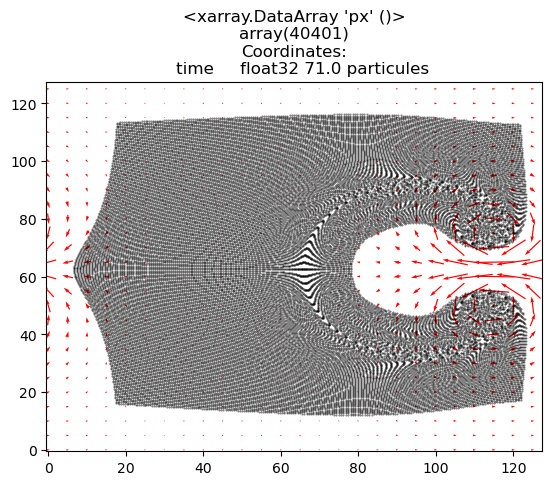

In [22]:

time = 10

# update time
simul.update(time)

#####################
# Recompute velocity field (using pyticles functions)

[u,v] = part.fluid2d_vel(simul)

#####################
# plot with particles

fig, ax = plt.subplots()

scale=5; col = 'k'
nnu,nnv=5,5        
x,y = np.mgrid[0:nxi,0:nyi]

qv = plt.quiver(x.T[::nnv,::nnu], y.T[::nnv,::nnu],\
           part.u2rho(u).T[::nnv,::nnu],part.v2rho(v).T[::nnv,::nnu],\
             pivot='mid',color='r',scale=scale);  

#########

plt.plot(lag.px[time,:]+0.5,lag.py[time,:]+0.5,'.', markersize=1., markerfacecolor=col,markeredgecolor=col,alpha=0.5)
plt.axis([-0.5 ,nxi-0.5, -0.5, nyi-0.5])

plt.title(format(np.sum(px>-1)) + ' particules ' )      
#plt.savefig(folderout + simulname +'_' + '{0:04}'.format(time+dfile) +'.png',  dpi=250,bbox_inches='tight'); plt.clf()




## Load other variables

In [77]:
# Load file
fluid2d_file  = xr.open_dataset(simul.file)

# add new coordinates (just indices for now)
fluid2d_file = fluid2d_file.assign_coords(xi=("x", range(nxi)))
fluid2d_file = fluid2d_file.assign_coords(yi=("y", range(nyi)))

###

fluid2d_file


<xarray.Dataset>
Dimensions:    (x: 128, y: 128, t: 501)
Coordinates:
  * x          (x) float32 0.003906 0.01172 0.01953 ... 0.9805 0.9883 0.9961
  * y          (y) float32 0.003906 0.01172 0.01953 ... 0.9805 0.9883 0.9961
  * t          (t) float32 0.0 0.2 0.4 0.6 0.8 1.0 ... 99.2 99.4 99.6 99.8 100.0
    xi         (x) int64 0 1 2 3 4 5 6 7 8 ... 120 121 122 123 124 125 126 127
    yi         (y) int64 0 1 2 3 4 5 6 7 8 ... 120 121 122 123 124 125 126 127
Data variables:
    msk        (y, x) int32 ...
    kt         (t) int32 ...
    vorticity  (t, y, x) float32 ...
    psi        (t, y, x) float32 ...
    tracer     (t, y, x) float32 ...
Attributes: (12/60)
    modelname:              euler
    expname:                vortex_00
    timestepping:           RK3_SSP
    order:                  3
    aparab:                 0.05
    flux_splitting_method:  parabolic
    ...                     ...
    print_param:            0
    tend:                   100
    plot_var:               vorticity
    cax:                    [-10.  10.]
    nbproc:                 1
    whosetspsi:             vorticity

0 0
1 50
CPU times: user 184 ms, sys: 2.86 ms, total: 187 ms
Wall time: 183 ms


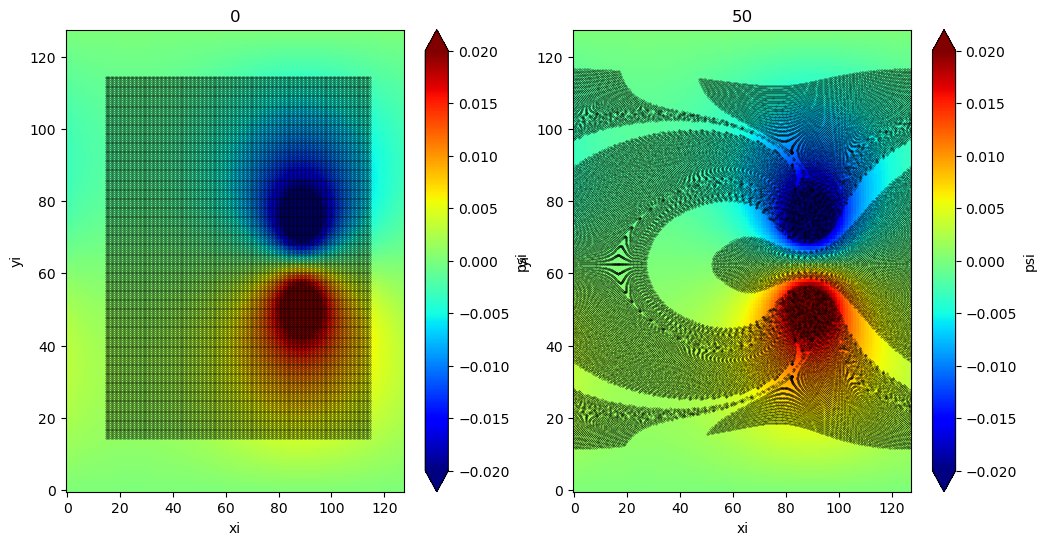

In [78]:
%%time

f, axes = plt.subplots(1, 2,figsize=(12,6))
marksize=0.2; colorpoint = 'black'; colorpointedge='black'
    
####

for it,time in enumerate([0,50]):

    print(it,time)
    ax = axes[it]
    
    fluid2d_file.psi.isel(t=time).plot(ax = ax, x = 'xi', y = 'yi', cmap='jet',vmin=-0.02,vmax=0.02)

    ax.set_title(time)
    # plot particles position on the domain
    ax.plot(lag.px[time,:]+0.5,lag.py[time,:]+0.5,'o',markersize=marksize,\
            markerfacecolor=colorpoint, markeredgecolor=colorpointedge)

    